In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sb

Import the dataset

In [13]:
df = pd.read_csv("Fraud.csv")

Apply Label encoding

The features named "nameOrig", "nameDest", "step" needs to be dropped. The explanation is given below

nameOrig = ID of the account from where the money is transferred. The variety of the accounts and the new accounts makes the feature useless.

nameDest = Id of the account where money is transferred. Same reason to drop as nameOrig.

step = Maps the time in hours for a transaction. Not a informative feature due to no relation between hourly timestamp and the fake transaction.

In [14]:
#The nameOrig and nameDest features are needed to be dropped because they are not fixed and will change if some new entry is evaluated
df = df.drop(['nameOrig', 'nameDest', 'step'], axis=1)

In [15]:
non_numeric_features = df.select_dtypes(exclude="number").columns.tolist()
print(non_numeric_features)
le = LabelEncoder()

for i in non_numeric_features:
    encoded_data = le.fit_transform(df[i])
    df[i] = encoded_data
    print(i, " encoding")
    temp = le.inverse_transform(df[i].unique())
    for j in range(len(df[i].unique())):
        print(j, " - ", temp[j])

['type']
type  encoding
0  -  PAYMENT
1  -  TRANSFER
2  -  CASH_OUT
3  -  DEBIT
4  -  CASH_IN


Fix missing values

In [16]:
df.replace([-np.inf, np.inf], np.nan, inplace=True)
df.dropna()
df

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,3,9839.64,170136.00,160296.36,0.00,0.00,0,0
1,3,1864.28,21249.00,19384.72,0.00,0.00,0,0
2,4,181.00,181.00,0.00,0.00,0.00,1,0
3,1,181.00,181.00,0.00,21182.00,0.00,1,0
4,3,11668.14,41554.00,29885.86,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...
6362615,1,339682.13,339682.13,0.00,0.00,339682.13,1,0
6362616,4,6311409.28,6311409.28,0.00,0.00,0.00,1,0
6362617,1,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0
6362618,4,850002.52,850002.52,0.00,0.00,0.00,1,0


Remove correlated features

         type      amount  newbalanceOrig  oldbalanceDest  isFraud  \
0           3     9839.64       160296.36            0.00        0   
1           3     1864.28        19384.72            0.00        0   
2           4      181.00            0.00            0.00        1   
3           1      181.00            0.00        21182.00        1   
4           3    11668.14        29885.86            0.00        0   
...       ...         ...             ...             ...      ...   
6362615     1   339682.13            0.00            0.00        1   
6362616     4  6311409.28            0.00            0.00        1   
6362617     1  6311409.28            0.00        68488.84        1   
6362618     4   850002.52            0.00            0.00        1   
6362619     1   850002.52            0.00      6510099.11        1   

         isFlaggedFraud  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
...

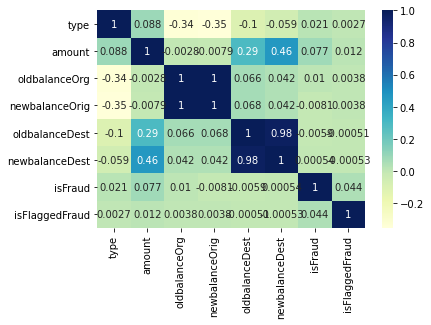

In [6]:
dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)

df_corr = df.corr()
thresold = 0.8
temp = len(df.columns)
for i in range(temp):
    for j in range(i+1, temp):
        if df_corr.iloc[i, j] >= thresold:
            df = df.drop(df.columns[i], axis=1)

print(df)

Remove outliers using mahalanobish distance formula

In [17]:
from scipy.stats import chi2

df_np = df.to_numpy()
covariance  = np.cov(df_np , rowvar=False)
covariance_transpose = np.linalg.matrix_power(covariance, -1)
centerpoint = np.mean(df_np , axis=0)

distances = []
for i, val in enumerate(df_np):
      p1 = val
      p2 = centerpoint
      distance = (p1-p2).T.dot(covariance_transpose).dot(p1-p2)
      distances.append(distance)

distances = np.array(distances)
cutoff = chi2.ppf(0.95, df_np.shape[1])
outlierIndexes = np.where(distances > cutoff )

print('Outliers')
print(outlierIndexes)

df = pd.DataFrame(df_np, columns=df.columns)

Outliers
(array([      2,       3,      24, ..., 6362617, 6362618, 6362619],
      dtype=int64),)


Balance the dataset for each label

In [18]:
x = df.drop('isFraud', axis=1)
y = df['isFraud']

In [19]:
#use SMOTE method for balancing dataset and see the result
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# summarize class distribution
counter = Counter(y)
print(counter)

# define pipeline
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=1.0)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X, Y = pipeline.fit_resample(x, y)

# summarize the new class distribution
counter = Counter(Y)
print(counter)

#create the train-test set
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size = 0.2, random_state=42, shuffle=True)

#Decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
dt = DecisionTreeClassifier()
dt.fit(xtrain, ytrain)
dt_predict = dt.predict(xtest)
decision_tree_score = dt.score(xtest, ytest)

print("Decision tree")
print(confusion_matrix(ytest, dt_predict))
print(decision_tree_score)

#Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain, ytrain)
nb_predict = nb.predict(xtest)
naive_bayes_score = nb.score(xtest, ytest)

print("Naive Bayes")
print(confusion_matrix(ytest, nb_predict))
print(naive_bayes_score)


Counter({0.0: 6354407, 1.0: 8213})
Counter({0.0: 3177203, 1.0: 3177203})
Decision tree
[[634575    469]
 [   278 635560]]
0.9994122192304242
Naive Bayes
[[623937  11107]
 [419258 216580]]
0.6613650991988241


In [20]:
#use replication strategy to get balanced dataset
import pandas as pd
from collections import Counter

# Suppose you have a dataset with features in 'X' and labels in 'y'

# Summarize class distribution
counter = Counter(y)
print("Original Class Distribution:", counter)

# Find the minority and majority class labels
minority_class = min(counter, key=counter.get)
majority_class = max(counter, key=counter.get)

# Find the ratio of oversampling (e.g., if you want to make the minority class equal to the majority class)
oversampling_ratio = counter[majority_class] // counter[minority_class]
oversampling_ratio += 1

# Separate the dataset into minority and majority class dataframes
minority_df = x[y == minority_class]
majority_df = x[y == majority_class]

# Duplicate the minority class samples to oversample
oversampled_minority_df = pd.concat([minority_df] * oversampling_ratio, ignore_index=True)

# Combine the oversampled minority class with the majority class dataframes
X_oversampled = pd.concat([majority_df, oversampled_minority_df], ignore_index=True)
y_oversampled = [majority_class] * len(majority_df) + [minority_class] * len(oversampled_minority_df)

# Create a new balanced dataset
# X_balanced = X_oversampled.iloc[balanced_indices]
# y_balanced = np.array(y_oversampled)[balanced_indices]

# # Summarize the balanced class distribution
# counter_balanced = Counter(y_balanced)
# print("Balanced Class Distribution:", counter_balanced)

# Summarize the new class distribution after oversampling
counter_oversampled = Counter(y_oversampled)
print("Oversampled Class Distribution:", counter_oversampled)

#create the train-test set
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_oversampled, y_oversampled, test_size = 0.2, random_state=42, shuffle=True)

#Decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
dt = DecisionTreeClassifier()
dt.fit(xtrain, ytrain)
dt_predict = dt.predict(xtest)
decision_tree_score = dt.score(xtest, ytest)

print("Decision tree")
print(confusion_matrix(ytest, dt_predict))
print(decision_tree_score)

#Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain, ytrain)
nb_predict = nb.predict(xtest)
naive_bayes_score = nb.score(xtest, ytest)

print("Naive Bayes")
print(confusion_matrix(ytest, nb_predict))
print(naive_bayes_score)


Original Class Distribution: Counter({0.0: 6354407, 1.0: 8213})
Oversampled Class Distribution: Counter({1.0: 6356862, 0.0: 6354407})
Decision tree
[[1270369     179]
 [      0 1271706]]
0.9999295900409636
Naive Bayes
[[1247321   23227]
 [ 877947  393759]]
0.6455216512590796


The replication seems to have better result than the SMOTE approach which is depicted by the confusion matrix and accuracy. The undersampling is not applied due to small quantity of samples of minority class

DO a comparative study of multiple models and choose the best

In [21]:
#create the train-test set
x = pd.DataFrame(X_oversampled)
y = pd.DataFrame(y_oversampled)
df = pd.concat([x, y], axis=1)
print(df)

          type      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0          3.0     9839.64      170136.00       160296.36            0.00   
1          3.0     1864.28       21249.00        19384.72            0.00   
2          3.0    11668.14       41554.00        29885.86            0.00   
3          3.0     7817.71       53860.00        46042.29            0.00   
4          3.0     7107.77      183195.00       176087.23            0.00   
...        ...         ...            ...             ...             ...   
12711264   1.0   339682.13      339682.13            0.00            0.00   
12711265   4.0  6311409.28     6311409.28            0.00            0.00   
12711266   1.0  6311409.28     6311409.28            0.00        68488.84   
12711267   4.0   850002.52      850002.52            0.00            0.00   
12711268   1.0   850002.52      850002.52            0.00      6510099.11   

          newbalanceDest  isFlaggedFraud    0  
0                   0.00   

In [22]:
df.iloc[:, -1].value_counts()

1.0    6356862
0.0    6354407
Name: 0, dtype: int64

In [24]:
#Decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
dt = DecisionTreeClassifier()
dt.fit(xtrain, ytrain)
dt_predict = dt.predict(xtest)
decision_tree_score = dt.score(xtest, ytest)

print("Decision tree")
print(confusion_matrix(ytest, dt_predict))
print(decision_tree_score)

#Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain, ytrain)
nb_predict = nb.predict(xtest)
naive_bayes_score = nb.score(xtest, ytest)

print("Naive Bayes")
print(confusion_matrix(ytest, nb_predict))
print(naive_bayes_score)

#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(xtrain, ytrain)
rf_predict = rf.predict(xtest)
random_forest_score = rf.score(xtest, ytest)

print("Random Forest")
print(confusion_matrix(ytest, rf_predict))
print(random_forest_score)

#K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(xtrain, ytrain)
knn_predict = knn.predict(xtest)
k_nearest_neighbours_score = knn.score(xtest, ytest)

print("K-Nearest Neighbours")
print(confusion_matrix(ytest, knn_predict))
print(k_nearest_neighbours_score)

Decision tree
[[1270368     180]
 [      0 1271706]]
0.9999291966892372
Naive Bayes
[[1247321   23227]
 [ 877947  393759]]
0.6455216512590796
Random Forest
[[1270409     139]
 [      0 1271706]]
0.999945324110022
K-Nearest Neighbours
[[1269079    1469]
 [      0 1271706]]
0.9994221663138302


the decision tree, knn and random forest seems to have the highest accuracy of all the models, and the dataset has no chance to be erroneous due to oversampled using replication, which would have been a issue if SMOTE approach would have been used.

In [25]:
#Store the best models and the labelencoder
import pickle

dt_path = "DTmodel.pkl"
rf_path = "RFmodel.pkl"
knn_path = "KNNmodel.pkl"
le_path = "labelencoder.pkl"

pickle_path = open(dt_path, 'wb')
pickle.dump(dt, pickle_path)
pickle_path = open(rf_path, 'wb')
pickle.dump(rf, pickle_path)
pickle_path = open(knn_path, 'wb')
pickle.dump(knn, pickle_path)
pickle_path = open(le_path, 'wb')
pickle.dump(le, pickle_path)

The model should be set in the system in such a way that, during a transaction all required features are needed to be calculated using the information in hand, prior to the transaction made possible. the data is then fed to the models to get a decision and based on the majority of decisions, the transaction is resumed or cancelled. Both the models have no chance of mistaking positive value as negetive, so the only issue is the mistaking fraud transaction as normal.

The model can be tested using cross validation which is already implemented in the scripts.